In [1]:
import os
import random
from os.path import join
from pathlib import Path

import pandas as pd
import numpy as np

book_train_dir = Path('../../data/raw/book_train/')
splits_dir = Path('../../data/splits/')
train_targets_path = Path('../../data/raw/train.csv')

os.makedirs(book_train_dir, exist_ok=True)
os.makedirs(splits_dir, exist_ok=True)

random.seed(0)

It seems like the competition test data contains the same stocks as the training data. This means we should be able to create models for each stock id instead of trying to make a general model for any stock. The following cell reserves 20 stocks as a final test set before submitting, but it may be more appropriate to do the same thing for each individual stock instead. For this cell and the rest of the notebook to work, you need to have the book_train data unzipped into the `data/raw/` directory. Once that's done the directory structure should look like this

```
|-- data
|   |-- raw
|   |   |-- book_train
|   |   |   |-- stock_id=0
|   |   |   |-- stock_id=1
|   |   |   |-- ...
|-- README.md
|-- LICENSE
|-- ...
```

In [2]:
stocks = os.listdir(book_train_dir)
# Sort the directory names so we can always be sure this provides the same split for a given seed.
stocks.sort()

from random import sample

train_stocks = sample(stocks, len(stocks) - 20)

train_stocks_path = join(splits_dir, 'train_stocks.txt')

with open(train_stocks_path, 'w+') as f:
    f.write(''.join([train_stock + '\n' for train_stock in train_stocks]))

For now we can just use these 5 stocks as toy data to do a bit of exploring with.

In [3]:
with open(train_stocks_path, 'r') as f:
    train_stocks_text = f.read()

train_stocks_text.split(sep='\n')[0:5]

['stock_id=96', 'stock_id=34', 'stock_id=84', 'stock_id=38', 'stock_id=102']

Data comes in parquet files, which pandas has support for. It's possible to just read `data/raw/book_train` and get the data for every stock, but I advise against this as it almost crashed my computer with how much memory it took.

In [4]:
df = pd.read_parquet('../../data/raw/book_train/stock_id=96')

In [5]:
df

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2
0,5,0,1.000766,1.001283,1.000747,1.001301,14,1,24,1
1,5,1,1.000766,1.001283,1.000747,1.001301,1,1,24,1
2,5,2,1.000932,1.001430,1.000914,1.001504,214,21,214,49
3,5,4,1.001061,1.001578,1.000969,1.001596,10,1,14,38
4,5,5,1.001061,1.001578,1.000747,1.001596,150,1,2,38
...,...,...,...,...,...,...,...,...,...,...
1717014,32767,593,0.999157,0.999543,0.999137,0.999563,100,100,100,100
1717015,32767,594,0.999157,0.999523,0.999137,0.999563,100,201,100,100
1717016,32767,595,0.999157,0.999503,0.999137,0.999563,100,102,100,100
1717017,32767,596,0.999137,0.999503,0.999117,0.999563,100,102,28,100


Since every row can be uniquely identified by `time_id` and `seconds_in_bucket`, reindexing based on these columns makes analysis a bit nicer.

In [6]:
df.index = pd.MultiIndex.from_frame(df[['time_id', 'seconds_in_bucket']])
df = df.drop(columns=['time_id', 'seconds_in_bucket'])

df

bid_price1  ask_price1  bid_price2  ask_price2  \
time_id seconds_in_bucket                                                   
5       0                    1.000766    1.001283    1.000747    1.001301   
        1                    1.000766    1.001283    1.000747    1.001301   
        2                    1.000932    1.001430    1.000914    1.001504   
        4                    1.001061    1.001578    1.000969    1.001596   
        5                    1.001061    1.001578    1.000747    1.001596   
...                               ...         ...         ...         ...   
32767   593                  0.999157    0.999543    0.999137    0.999563   
        594                  0.999157    0.999523    0.999137    0.999563   
        595                  0.999157    0.999503    0.999137    0.999563   
        596                  0.999137    0.999503    0.999117    0.999563   
        598                  0.999035    0.999279    0.999015    0.999442   

                           bid_size1  ask_size1  bid_size2  ask_size2  
time_id seconds_in_bucket                                              
5       0                         14          1         24          1  
        1                          1          1         24          1  
        2                        214         21        214         49  
        4                         10          1         14         38  
        5                        150          1          2         38  
...                              ...        ...        ...        ...  
32767   593                      100        100        100        100  
        594                      100        201        100        100  
        595                      100        102        100        100  
        596                      100        102         28        100  
        598                        1        100         31         28  

[1717019 rows x 8 columns]

There is roughly 10 minutes of data in each time bucket. `seconds_in_bucket` is not continuous, some seconds are missing.

In [7]:
df.loc[5]

,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2
seconds_in_bucket,,,,,,,,
0,1.000766,1.001283,1.000747,1.001301,14,1,24,1
1,1.000766,1.001283,1.000747,1.001301,1,1,24,1
2,1.000932,1.001430,1.000914,1.001504,214,21,214,49
4,1.001061,1.001578,1.000969,1.001596,10,1,14,38
5,1.001061,1.001578,1.000747,1.001596,150,1,2,38
...,...,...,...,...,...,...,...,...
592,1.005472,1.006506,1.005343,1.006598,250,9,25,36
594,1.005472,1.006506,1.005343,1.006598,350,9,25,36
595,1.005472,1.006506,1.005343,1.006598,250,9,25,36


In [8]:
np.sqrt((df['bid_price1'] + df['ask_price1']).groupby(level='time_id').sum())

time_id
5        30.548985
11       28.242567
16       29.794979
31       28.969864
62       30.070969
           ...    
32751    32.109413
32753    29.843603
32758    28.229603
32763    31.988819
32767    27.994925
Length: 3830, dtype: float32

Realized volatility calculation:

In [9]:
def realized_volatility(book_data):
    wap = (book_data['bid_price1'] * book_data['ask_size1'] + book_data['ask_price1'] * book_data['bid_size1']) / (book_data['bid_size1'] + book_data['ask_size1'])
    log_wap = np.log(wap)
    
    log_returns = log_wap.groupby(level='time_id').diff().dropna()
    
    return np.sqrt((log_returns**2).groupby(level='time_id').sum())

In [10]:
past_realized_volatility = realized_volatility(df)

past_realized_volatility

time_id
5        0.005659
11       0.002495
16       0.002998
31       0.002414
62       0.002116
           ...   
32751    0.004506
32753    0.003057
32758    0.003227
32763    0.003331
32767    0.002667
Length: 3830, dtype: float64

We can compare this with the target realized volatility from `train.csv`.

In [11]:
train_targets_df = pd.read_csv(train_targets_path)
train_targets_df.index = pd.MultiIndex.from_frame(train_targets_df[['stock_id', 'time_id']])

targets = train_targets_df['target']

# Put both past and target in same dataframe for side-by-side comparison and graphing.
comparison_df = pd.DataFrame({'past': past_realized_volatility, 'target': targets.loc[96]})

comparison_df

,past,target
time_id,,
5,0.005659,0.005130
11,0.002495,0.002393
16,0.002998,0.003085
31,0.002414,0.002384
62,0.002116,0.002936
...,...,...
32751,0.004506,0.004332
32753,0.003057,0.002848
32758,0.003227,0.002858


Plot of past volatility vs target volatility suggests a linear relationship.

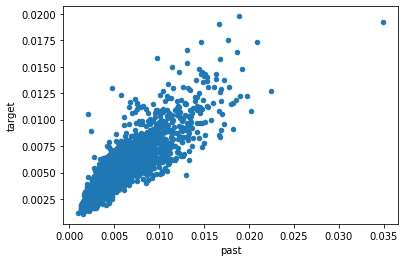

In [12]:
_ = comparison_df.plot(x='past', y='target', kind='scatter')

#### Next Steps

For a baseline we should replicate the tutorial method of using past volatility as the predicted target. We should then try a linear model based on past volatility. From there best thing to do should be feature engineering, we still have the trade data to tap into, and there are other features we can take from the book data. For a high dimensionality approach we could try taking summary stats for short time intervals throughout each bucket and feed them into something like an SVM.

A competitive model would probably recognize the data as time series data, but I want to get some practice with the more basic learning methods before getting into time series analysis.